In [1]:
import pandas as pd
import plotnine as p9
import numpy as np
df = pd.read_parquet("../data/preprocessed.parquet")

In [2]:
# These columns are pointless to plot, and take a long time
df.drop(labels=['description', 'service_id'], axis=1, inplace=True)
df.columns

Index(['affected', 'cause', 'duration', 'duration_min', 'first_notification',
       'half_desc', 'hour_of_week', 'last_notification', 'location', 'monitor',
       'org_type', 'range', 'service_name', 'services', 'severity', 'status',
       'users', 'vendor'],
      dtype='object')

In [3]:
def filter_notprovided(series, keep=False):
    from numpy import ndarray as nparr
    if keep:
        if type(series.iloc[0]) == nparr:
            return series.map(lambda x: x.tolist() == ['not provided'])
        else:
            return series.map(lambda x: x == 'not provided')
    
    if type(series.iloc[0]) == nparr:
        return series.map(lambda x: x.tolist() != ['not provided'])
    else:
        return series.map(lambda x: x != 'not provided')

In [4]:
def len_and_pct(partdf, wholedf):
    pct = f'{round(len(partdf)/float(len(wholedf))*100, 2)}%'
    return (len(partdf), pct)


Not provided:
- cause: 26 (23.85%)



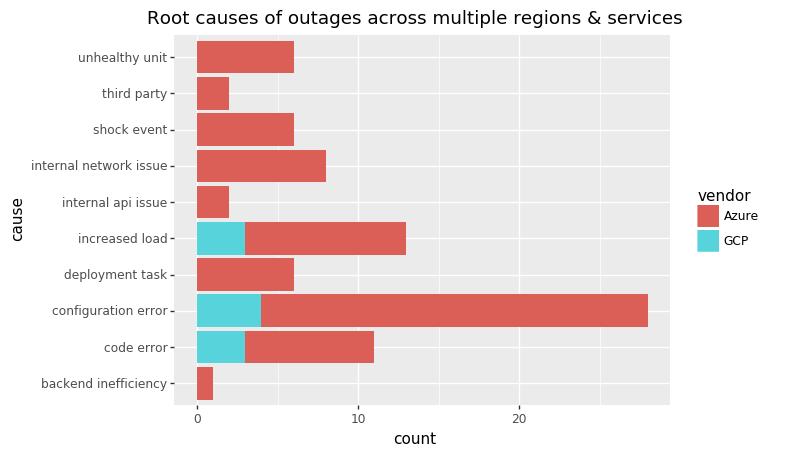

<ggplot: (283613981)>

In [5]:
mul_regs_and_svcs = df.query("range == 'multiple regions' and services == 'multiple'")

print(f'''
Not provided:
- cause: {"%d (%s)" % len_and_pct(mul_regs_and_svcs[filter_notprovided(mul_regs_and_svcs.cause, keep=True)], mul_regs_and_svcs)}
''')

filt = mul_regs_and_svcs[filter_notprovided(mul_regs_and_svcs.cause)]
plotdf = pd.DataFrame({'cause': filt.cause.map(lambda x: ','.join(x)),
                       'vendor': filt.vendor})
(p9.ggplot(plotdf)
 + p9.aes(x='cause', fill='vendor')
 + p9.geom_bar()
 + p9.coord_flip()
 + p9.ggtitle("Root causes of outages across multiple regions & services")
)

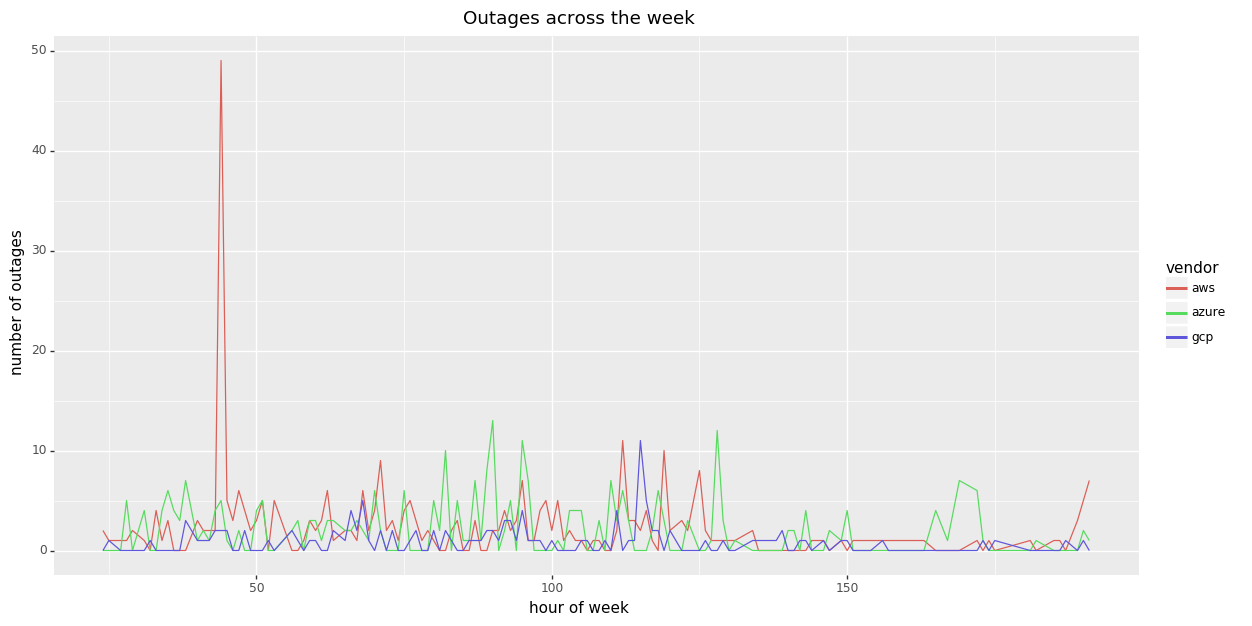

<ggplot: (318986705)>

In [6]:
import numpy as np
azure_hours = df[df.vendor == "Azure"].hour_of_week.value_counts()
aws_hours = df[df.vendor == "AWS"].hour_of_week.value_counts()
gcp_hours = df[df.vendor == "GCP"].hour_of_week.value_counts()

plotdf = pd.DataFrame({'azure': azure_hours,
                       'gcp': gcp_hours,
                       'aws': aws_hours}).applymap(lambda x: 0 if pd.isna(x) else x).reset_index(level=df.index.names)
                     

(p9.ggplot(plotdf.melt(id_vars=['index'], var_name='vendor', value_name='outages_count'))
 + p9.aes(x='index', y='outages_count', color='vendor')
 + p9.geom_line()
 + p9.labs(x='hour of week', y='number of outages')
 + p9.theme(figure_size=(14, 7))
 + p9.ggtitle("Outages across the week")
)


Not provided:
- cause: 435 (58.7%)
- affected: 39 (5.26%)



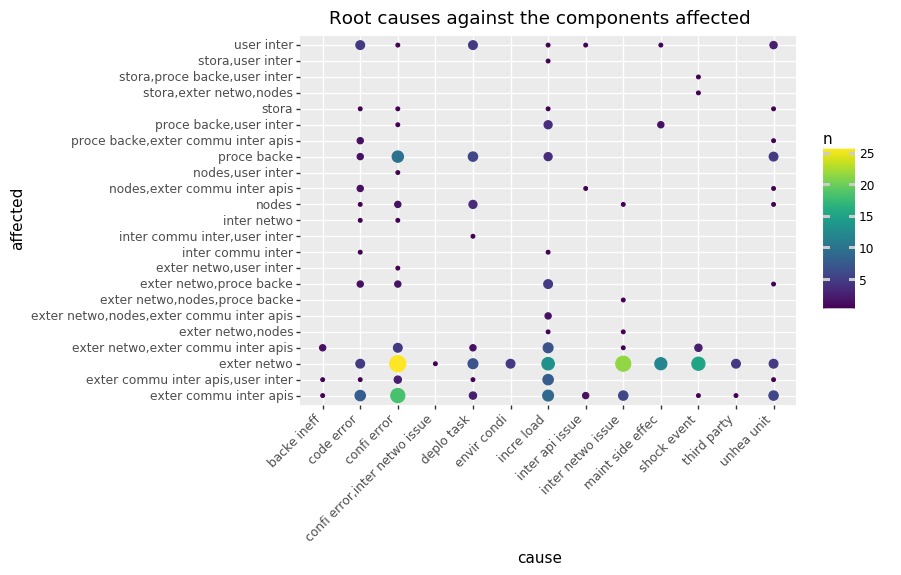

<ggplot: (315125845)>

In [7]:
def abbrev(s):
    import re
    words = s.split()
    shortened = [re.sub('[\(\)]', '', x)[0:5] for x in words]
    return " ".join(shortened)


print(f'''
Not provided:
- cause: {len_and_pct(df[filter_notprovided(df.cause, keep=True)], df)[0]} ({len_and_pct(df[filter_notprovided(df.cause, keep=True)], df)[1]})
- affected: {len_and_pct(df[filter_notprovided(df.affected, keep=True)], df)[0]} ({len_and_pct(df[filter_notprovided(df.affected, keep=True)], df)[1]})
''')

plotdf = df[filter_notprovided(df.cause) & filter_notprovided(df.affected)][['cause', 'affected']].applymap(lambda x: ','.join(map(abbrev, x)))
(p9.ggplot(plotdf)
 + p9.aes(x='cause', y='affected', color='..n..')
 + p9.geom_count(show_legend={'size': False})
 + p9.ggtitle("Root causes against the components affected")
 + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)


Not provided:
- severity: 30 (4.05%)
- users: 7 (0.94%)
- affected: 39 (5.26%)



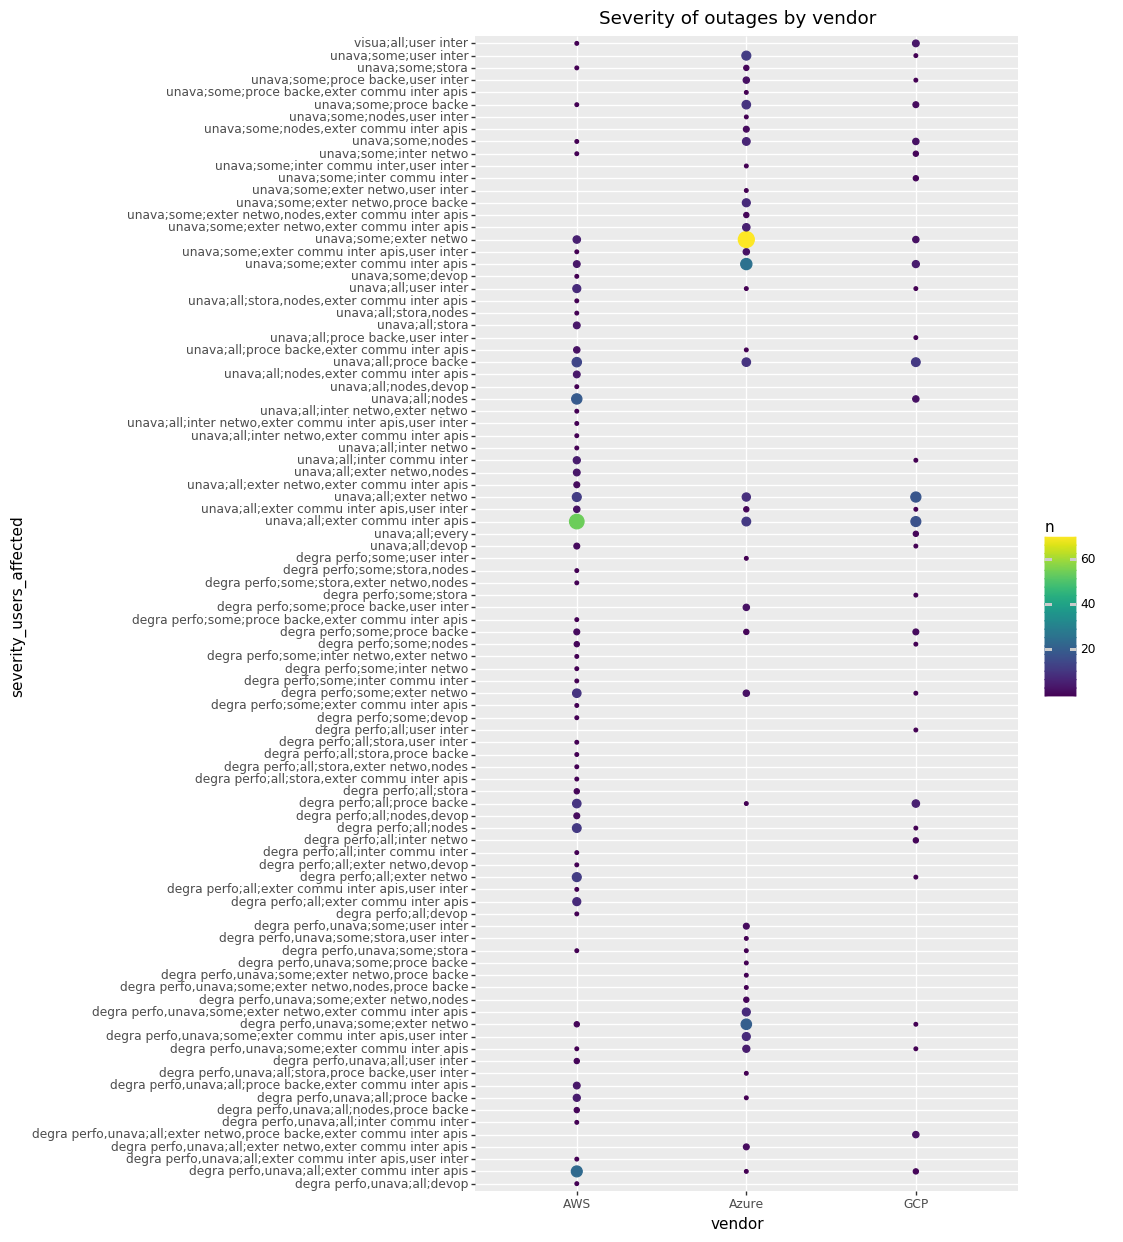

<ggplot: (316574253)>

In [8]:
# severity+users+duration vs vendor
print(f'''
Not provided:
- severity: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.severity, keep=True)], df)}
- users: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.users, keep=True)], df)}
- affected: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.affected, keep=True)], df)}
''')

filtered = df[filter_notprovided(df.severity) & filter_notprovided(df.users) & filter_notprovided(df.affected)]

(p9.ggplot(pd.DataFrame({'severity_users_affected': filtered.severity.map(lambda x: ','.join(map(abbrev, x)))+';'+filtered.users+';'+filtered.affected.map(lambda x: ','.join(map(abbrev, x))),
                         'vendor': filtered.vendor}))
 + p9.aes(x='vendor', y='severity_users_affected', color='..n..')
 + p9.geom_count(show_legend={'size': False})
 + p9.theme(figure_size=(7, 15))
 + p9.ggtitle("Severity of outages by vendor")
)


Not provided:
- affected: 39 (5.26%)



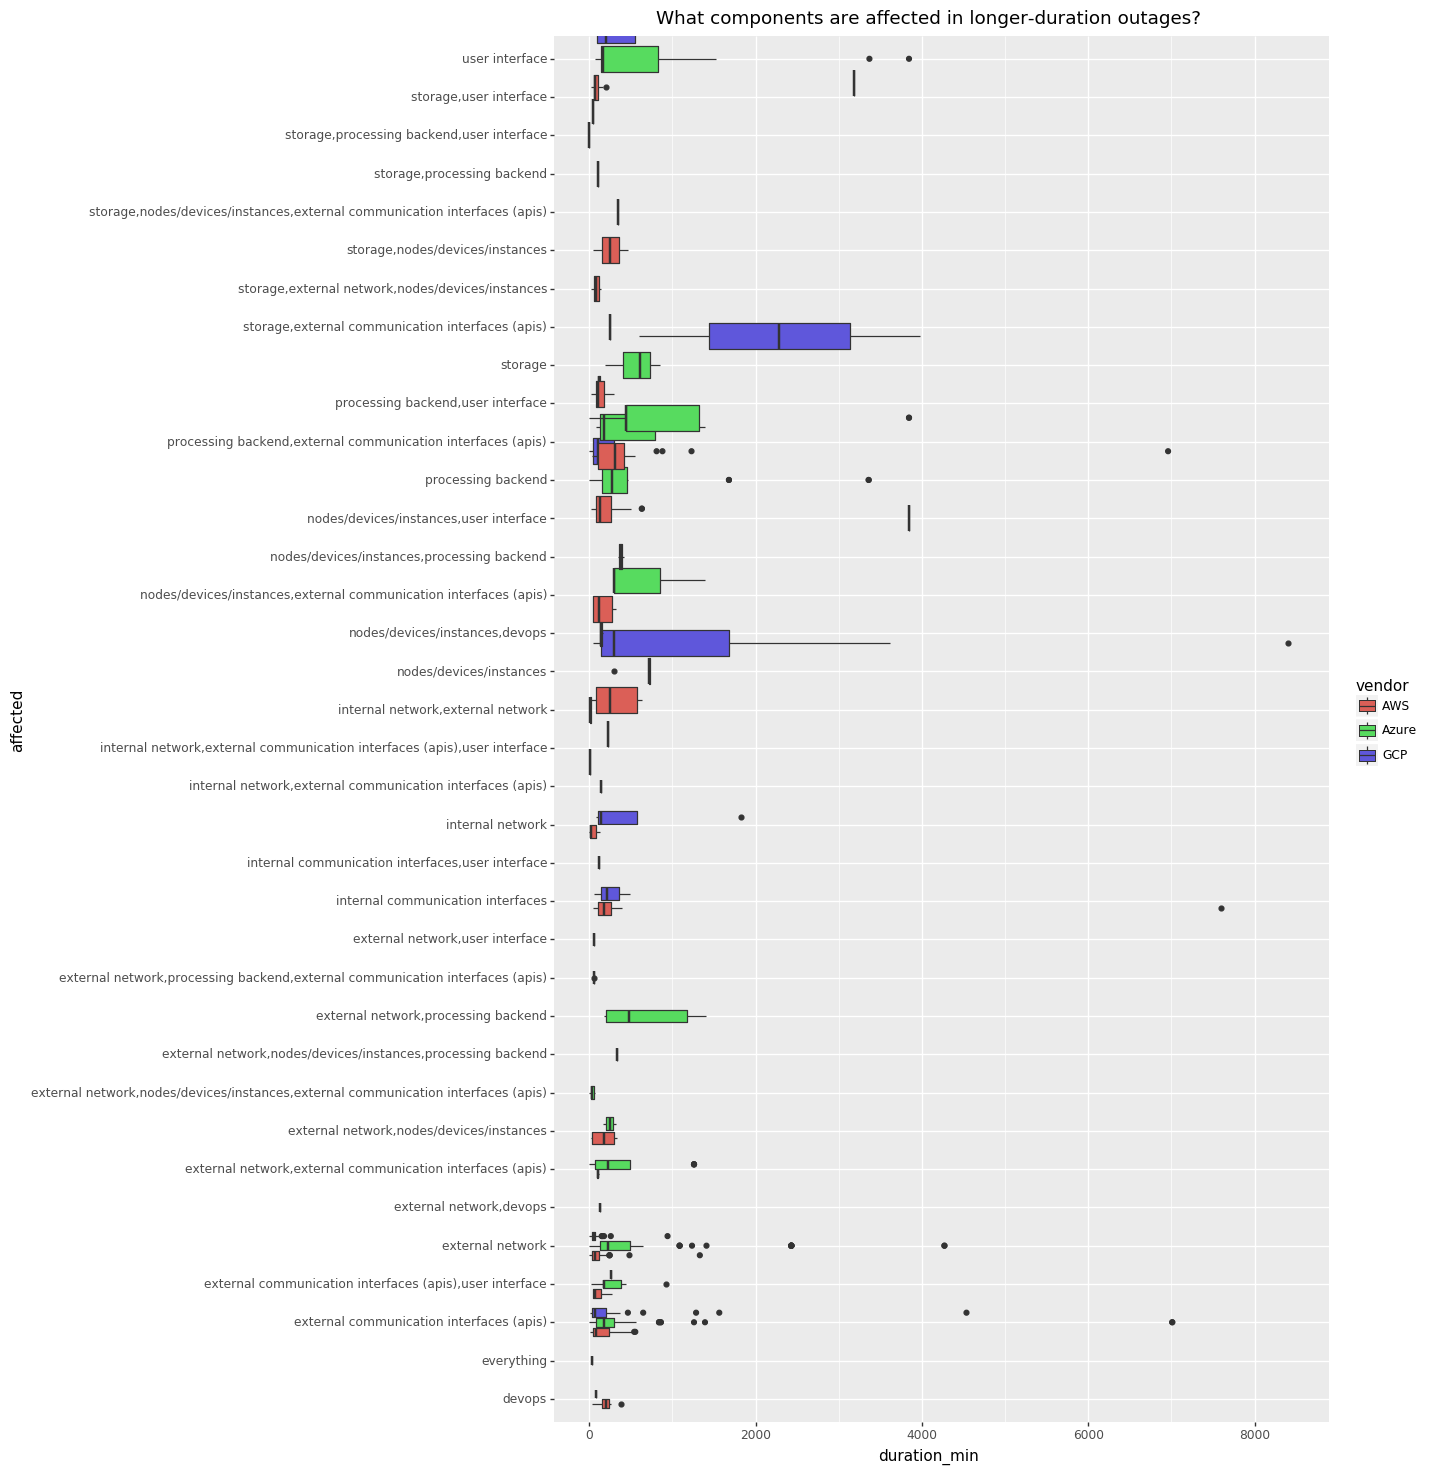

<ggplot: (318990457)>

In [9]:
print(f'''
Not provided:
- affected: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.affected, keep=True)], df)}
''')

filtered = df[filter_notprovided(df.affected)]
plotdf = pd.DataFrame({'affected': filtered.affected.map(lambda x: ','.join(x)),
                       'duration_min': filtered.duration_min,
                       'vendor': filtered.vendor})
(p9.ggplot(plotdf.melt(id_vars=['vendor', 'affected'], value_vars=['duration_min'], value_name='duration_min'))
 + p9.aes(y='duration_min', x='affected', fill='vendor')
 + p9.geom_boxplot()
 + p9.theme(figure_size=(10, 18))
 + p9.coord_flip()
 + p9.ggtitle("What components are affected in longer-duration outages?")
)


Not provided:
- cause: 435 (58.7%)



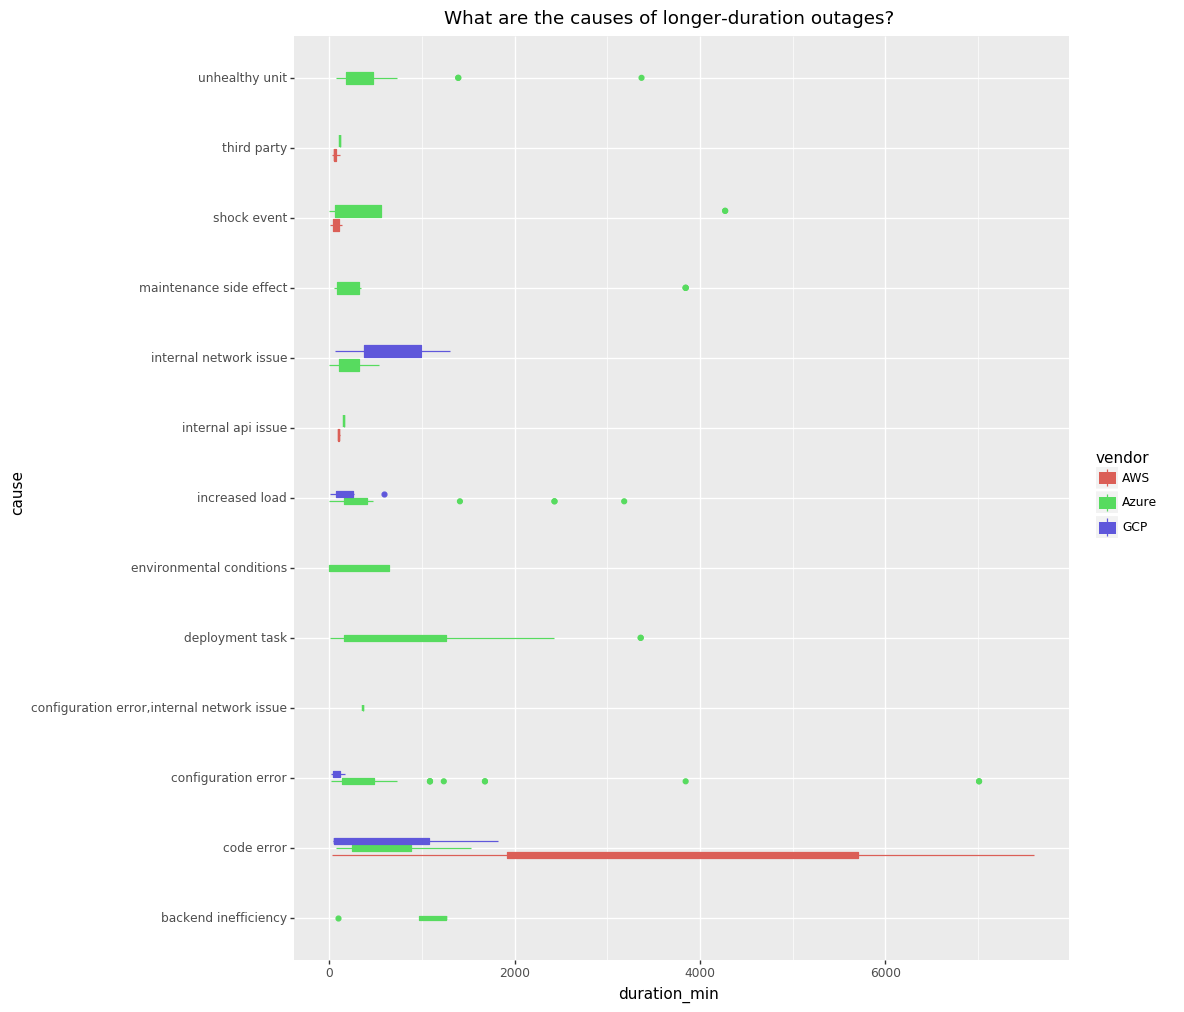

<ggplot: (319996813)>

In [10]:
print(f'''
Not provided:
- cause: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.cause, keep=True)], df)}
''')

filt = df[filter_notprovided(df.cause)]
plotdf = pd.DataFrame({'cause': filt.cause.map(lambda x: ','.join(x)),
                       'duration_min': filt.duration_min,
                       'vendor': filt.vendor})

(p9.ggplot(plotdf.melt(id_vars=['vendor', 'cause'], value_vars=['duration_min'], value_name='duration_min'))
 + p9.aes(y='duration_min', x='cause', fill='vendor', color='vendor')
 + p9.geom_boxplot(width=0.2)
 + p9.theme(figure_size=(10, 12))
 + p9.coord_flip()
 + p9.ggtitle("What are the causes of longer-duration outages?")
)


Not provided:
- users: 7 (0.94%)
- range: 6 (0.81%)



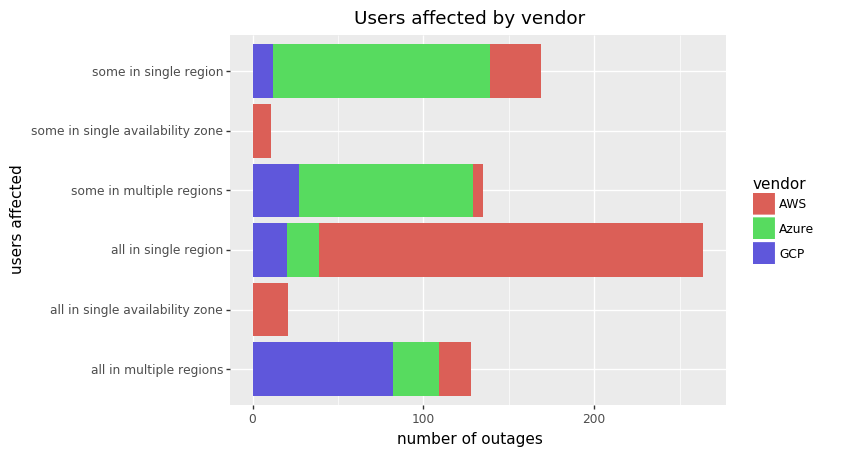

<ggplot: (320008465)>

In [11]:
print(f'''
Not provided:
- users: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.users, keep=True)], df)}
- range: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.range, keep=True)], df)}
''')

filt = df[filter_notprovided(df.users) & filter_notprovided(df.range)]
plotdf = pd.DataFrame({'users_range': filt.users+' in '+filt.range,
                       'vendor': filt.vendor})
(p9.ggplot(plotdf)
 + p9.aes(x='users_range', fill='vendor')
 + p9.geom_bar()
 + p9.labs(x='users affected', y='number of outages')
 + p9.coord_flip()
 + p9.ggtitle("Users affected by vendor")
)


Not provided:
- users: 7 (0.94%)
- range: 6 (0.81%)
- severity: 30 (4.05%)
- duration: 25 (3.37%)



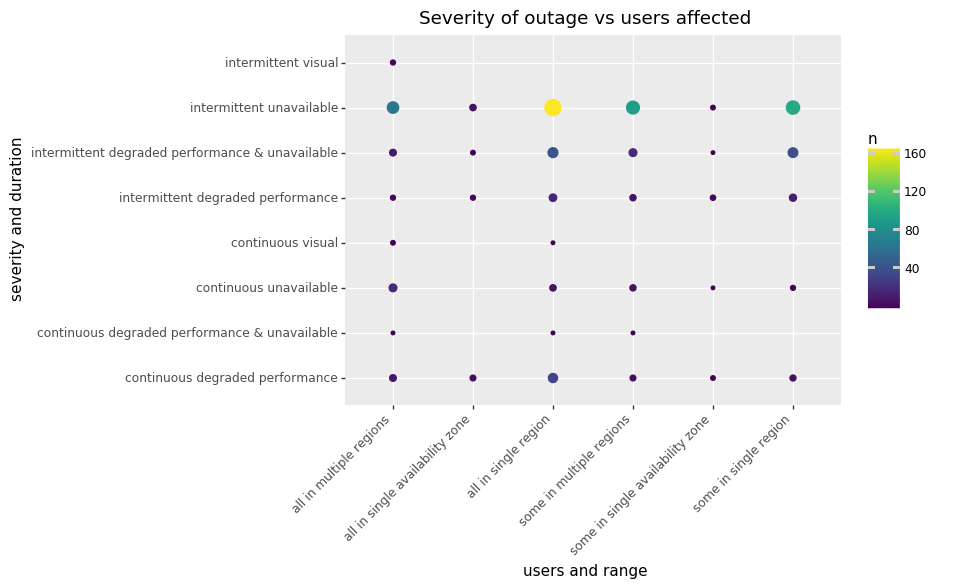

<ggplot: (319427365)>

In [12]:
print(f'''
Not provided:
- users: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.users, keep=True)], df)}
- range: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.range, keep=True)], df)}
- severity: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.severity, keep=True)], df)}
- duration: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.duration, keep=True)], df)}
''')

filt = df[filter_notprovided(df.users) & filter_notprovided(df.range) & filter_notprovided(df.severity) & filter_notprovided(df.duration)]
plotdf = pd.DataFrame({'users and range': filt.users+' in '+filt.range,
                       'severity and duration': filt.duration+' '+filt.severity.map(lambda x: ' & '.join(x))})

(p9.ggplot(plotdf)
 + p9.aes(x='users and range', y='severity and duration', color='..n..')
 + p9.geom_count(show_legend={'size': False})
 + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
 + p9.ggtitle("Severity of outage vs users affected")
)


Not provided:
- affected: 39 (5.26%)
- range: 6 (0.81%)
- users: 7 (0.94%)



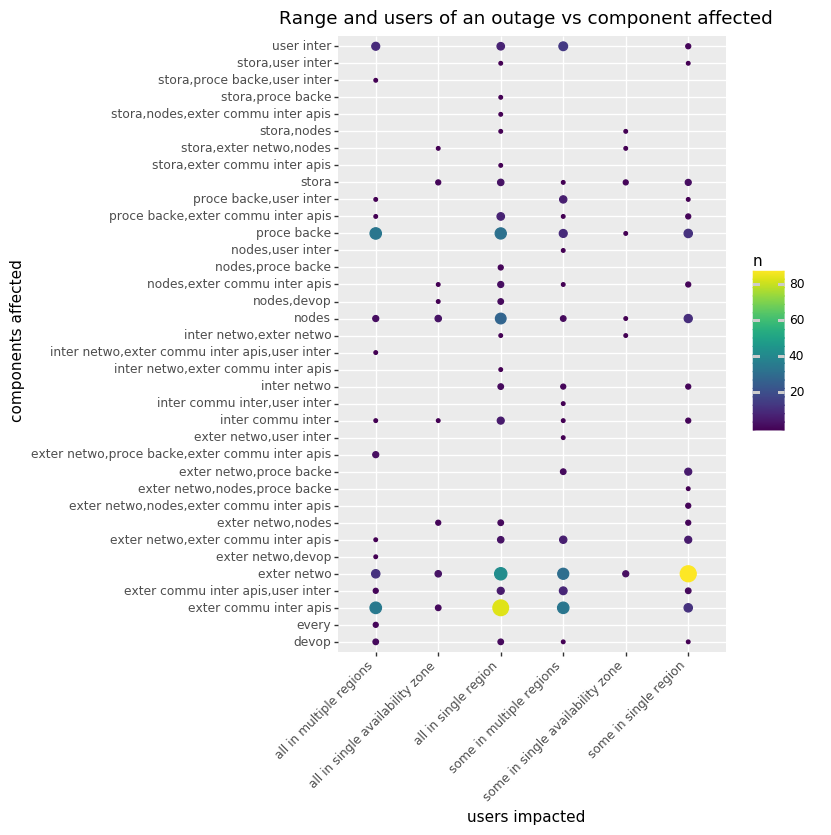

<ggplot: (319593989)>

In [13]:
print(f'''
Not provided:
- affected: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.affected, keep=True)], df)}
- range: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.range, keep=True)], df)}
- users: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.users, keep=True)], df)}
''')

filt = df[filter_notprovided(df.affected) & filter_notprovided(df.range) & filter_notprovided(df.users)]
plotdf = pd.DataFrame({'affected': filt.affected.map(lambda x: ','.join(map(abbrev, x))), 
                       'range_users': filt.users+' in '+filt.range, 
                       'vendor': filt.vendor})
(p9.ggplot(plotdf)
 + p9.aes(x='range_users', y='affected', color='..n..')
 + p9.geom_count(show_legend={'size': False})
 + p9.theme(figure_size=(5, 8), axis_text_x=p9.element_text(rotation=45, hjust=1))
 + p9.ggtitle("Range and users of an outage vs component affected")
 + p9.labs(x="users impacted", y='components affected')
)


Not provided:
- cause: 435 (58.7%)
- range: 6 (0.81%)
- users: 7 (0.94%)



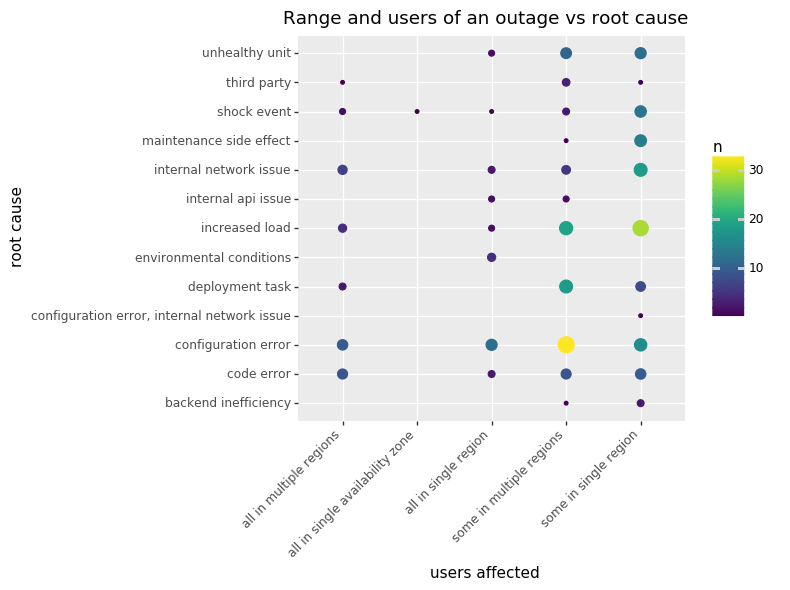

<ggplot: (320008549)>

In [14]:
print(f'''
Not provided:
- cause: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.cause, keep=True)], df)}
- range: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.range, keep=True)], df)}
- users: {"%d (%s)" % len_and_pct(df[filter_notprovided(df.users, keep=True)], df)}
''')

filt = df[filter_notprovided(df.cause) & filter_notprovided(df.range) & filter_notprovided(df.users)]
plotdf = pd.DataFrame({'cause': filt.cause.map(lambda x: ', '.join(x)), 
                       'range_users': filt.users+' in '+filt.range,
                       'vendor': filt.vendor})
(p9.ggplot(plotdf)
 + p9.aes(x='range_users', y='cause', color='..n..')
 + p9.geom_count(show_legend={'size': False})
 + p9.theme(figure_size=(5, 5), axis_text_x=p9.element_text(rotation=45, hjust=1))
 + p9.ggtitle("Range and users of an outage vs root cause")
 + p9.labs(x='users affected', y='root cause')
)

In [15]:
# from itertools import combinations, chain
# import numpy as np

# def powerset_noempty(iterable):
#     s = list(iterable)
#     return list(filter(bool, map(list, chain.from_iterable(list(combinations(s, r)) for r in range(len(s)+1)))))

# def islist(col):
#     return col.map(type).eq(np.ndarray).all()
# def isstr(col):
#     return col.map(type).eq(str).all()

# def abbrev(s):
#     import re
#     words = s.split()
#     shortened = [re.sub('[\(\)]', '', x)[0:5] for x in words]
#     return " ".join(shortened)

# plots = []
# for pair in list(combinations(df.columns, 2)):
    
#     if isstr(df[pair[0]]) and isstr(df[pair[1]]):
#         plotpart = p9.ggplot(df, p9.aes(x=pair[0], y=pair[1]))
        
#     else:
#         # Make a temp dataframe to hold reformatted values
#         df_tmp = pd.DataFrame()
#         if islist(df[pair[0]]):
#             df_tmp[pair[0]] = df[pair[0]].apply(lambda x: ','.join(map(abbrev, x)))
#         else:
#             df_tmp[pair[0]] = df[pair[0]]
            
#         if islist(df[pair[1]]):
#             df_tmp[pair[1]] = df[pair[1]].apply(lambda x: ','.join(map(abbrev, x)))
#         else:
#             df_tmp[pair[1]] = df[pair[1]]
        
#         plotpart = p9.ggplot(df_tmp, p9.aes(x=pair[0], y=pair[1]))

    
#     if pair[0] == 'hour_of_week':       
#         plots.append(plotpart
#                      + p9.geom_jitter()
#                      + p9.scales.xlim(0, 24*7))
#     elif pair[1] == 'hour_of_week':
#         plots.append(plotpart
#                      + p9.geom_jitter() 
#                      + p9.scales.ylim(0, 24*7))
#     else:
#         plots.append(plotpart + dsp_opt)